### Ridge Regression Model for Predicting log(C‑Peptide AUC)

We model the log‑transformed 4‑hour C‑peptide AUC as a linear function of autoantibodies and demographics.

<div style="text-align: left">

$$
\log(\text{C‑peptide AUC}) =
\beta_0
+ \beta_{\text{GAD65}} \cdot \text{GAD65}
+ \beta_{\text{IA2IC}} \cdot \text{IA2IC}
+ \beta_{\text{MIAA}} \cdot \text{MIAA}
+ \beta_{\text{ICA}} \cdot \text{ICA}
+ \beta_{\text{ZNT8}} \cdot \text{ZNT8}
+ \beta_{8\text{–}12} \cdot I_{8\text{–}12}
+ \beta_{13\text{–}17} \cdot I_{13\text{–}17}
+ \beta_{>18} \cdot I_{>18}
+ \beta_{\text{Sex}} \cdot \text{Sex}
$$
</div>

Where:

**Where:**

- $ \beta_0 $ is the intercept  
- $ \beta_i $ are the learned Ridge regression coefficients  
- $ I_{\text{Age Group}} $ is a one-hot encoded indicator for age group  
- Sex is encoded as 0 = Male, 1 = Female


This model is trained using Ridge regression to stabilize coefficients across small, multi‑study datasets and enable federated coefficient averaging.

This Ridge regression model is trained separately for each study using local data and evaluated using mean squared error (MSE), median squared error, and interquartile range (IQR).  
We then compare this local performance to a **federated Ridge model** constructed by aggregating coefficients across studies.


In [1]:
import os
# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [2]:
# === Feature Data Paths (raw tidy files) ===
feature_paths = {
    "SDY569": "data/SDY569_tidy.csv",
    "SDY797": "data/SDY797_tidy.csv",
    "SDY1737": "data/SDY1737_tidy.csv"
}

# === Ground Truth C-Peptide Labels ===
cpeptide_paths = {
    "SDY569": "data/SDY569_cpeptide_auc_tidy.csv",
    "SDY797": "data/SDY797_cpeptide_auc_tidy.csv",
    "SDY1737": "data/SDY1737_cpeptide_auc_tidy.csv"
}

# === CNN Output Features (Used for Ridge Regression) ===
# These were saved from the trained CNNs, so they include "Accession" for alignment
cnn_test_feature_paths = {
    "SDY569": "test_data/SDY569_3x3_test.csv",
    "SDY797": "test_data/SDY797_3x3_test.csv",
    "SDY1737": "test_data/SDY1737_3x3_test.csv"
}

# === Local CNN Model Paths ===
local_model_paths = {
    "SDY569": "models/SDY569_3x3_model.keras",
    "SDY797": "models/SDY797_3x3_model.keras",
    "SDY1737": "models/SDY1737_3x3_model.keras",  # ← FIXED typo (was SD1737)
}

# === Federated CNN Model Path ===
federated_model_path = {
    "federated": "models/federated_3x3_model.keras",
}

# === Retrained CNN Model Paths (fine-tuned per-study) ===
retrained_model_paths = {
    "SDY569": "models/SDY569_RETRAINED_3x3_model.keras",
    "SDY797": "models/SDY797_RETRAINED_3x3_model.keras",
    "SDY1737": "models/SDY1737_RETRAINED_3x3_model.keras",  # ← FIXED typo (was SD1737)
}
#
## note about SDY797 - results on Autoantibodies were positive or negative -- not a continuous value

In [4]:
import pandas as pd

# Load all feature, label, and CNN test data
feature_dfs   = {study: pd.read_csv(path) for study, path in feature_paths.items()}
cpeptide_dfs  = {study: pd.read_csv(path) for study, path in cpeptide_paths.items()}
cnn_test_dfs  = {study: pd.read_csv(path) for study, path in cnn_test_feature_paths.items()}

# Merge feature + label data on Subject_ID
merged_dfs = {}

for study in feature_dfs:
    print(f"\nMerging data for {study}")

    df_feat = feature_dfs[study].copy()
    df_cpep = cpeptide_dfs[study].copy()

    # Rename "Accession" → "Subject_ID" if needed
    if "Accession" in df_feat.columns:
        df_feat = df_feat.rename(columns={"Accession": "Subject_ID"})

    if "Subject_ID" not in df_feat.columns or "Subject_ID" not in df_cpep.columns:
        raise ValueError(f"Missing 'Subject_ID' in {study}")

    merged = pd.merge(df_feat, df_cpep, on="Subject_ID", how="inner")
    merged_dfs[study] = merged

    print(f"  Feature shape:  {df_feat.shape}")
    print(f"  C-peptide shape:{df_cpep.shape}")
    print(f"  Merged shape:   {merged.shape}")
    print("  Sample rows from merged data:")
    print(merged.head(3))



Merging data for SDY569
  Feature shape:  (30, 6)
  C-peptide shape:(10, 6)
  Merged shape:   (30, 11)
  Sample rows from merged data:
  Subject_ID     Sex Age_Group Property  Value Study_x Study_y  \
0  SUB151307  Female      8-12    GAD65   0.04  SDY569  SDY569   
1  SUB151307  Female      8-12    IA2IC   0.71  SDY569  SDY569   
2  SUB151307  Female      8-12     MIAA   2.08  SDY569  SDY569   

    Participant_ID Visit_Label  C_Peptide_AUC_4Hrs  Units  
0  ITN007AI_195962    Baseline              0.5625  NG/ML  
1  ITN007AI_195962    Baseline              0.5625  NG/ML  
2  ITN007AI_195962    Baseline              0.5625  NG/ML  

Merging data for SDY797
  Feature shape:  (245, 6)
  C-peptide shape:(49, 6)
  Merged shape:   (245, 11)
  Sample rows from merged data:
  Subject_ID   Sex Age_Group Property  Value Study_x Study_y Participant_ID  \
0  SUB168890  Male      8-12    GAD65    1.0  SDY797  SDY797   T1DAL_137962   
1  SUB168890  Male      8-12    IA2IC    0.0  SDY797  SDY797   

In [5]:
# Convert tidy long-format to wide format for plotting
wide_feature_dfs = {}

for study, df in feature_dfs.items():
    print(f"Converting {study} to wide format...")

    # Pivot Property → Columns
    df_wide = df.pivot_table(
        index=["Accession", "Sex", "Age_Group"],
        columns="Property",
        values="Value"
    ).reset_index()

    wide_feature_dfs[study] = df_wide


Converting SDY569 to wide format...
Converting SDY797 to wide format...
Converting SDY1737 to wide format...



Distributions for SDY569:


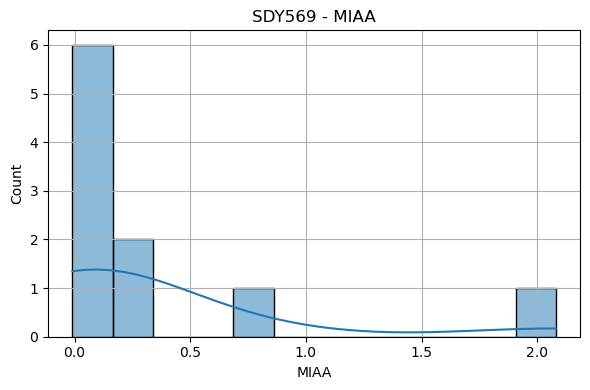

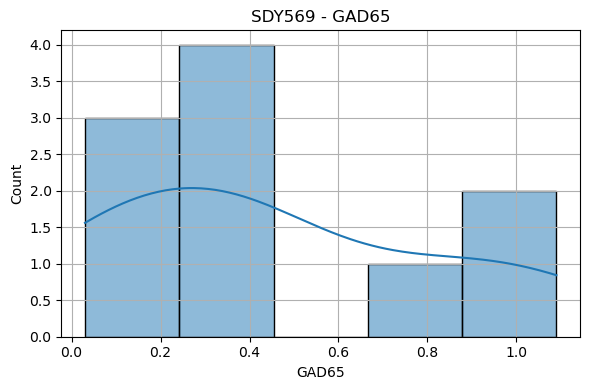

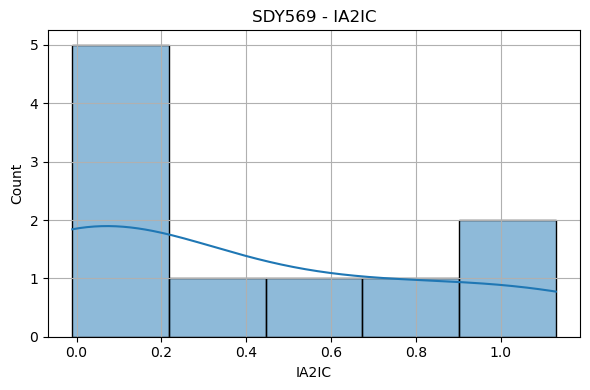

  [SKIP] ICA not found in SDY569
  [SKIP] ZNT8 not found in SDY569

Distributions for SDY797:


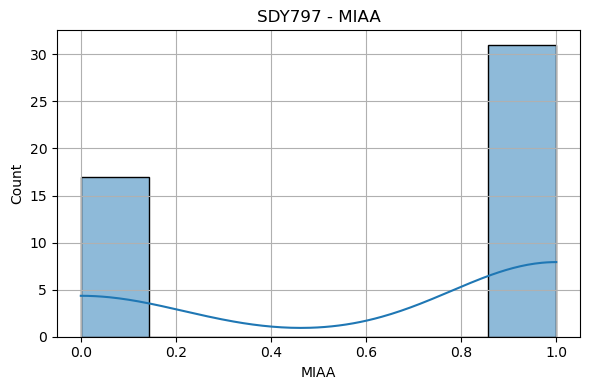

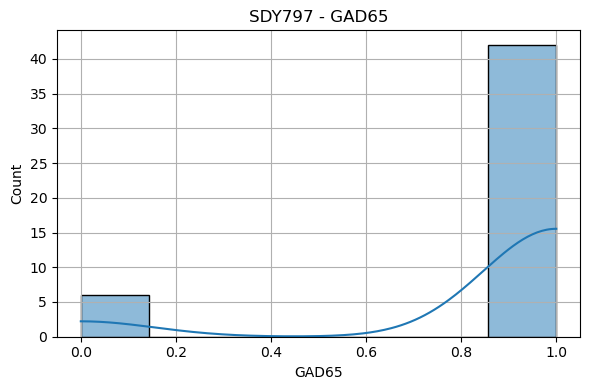

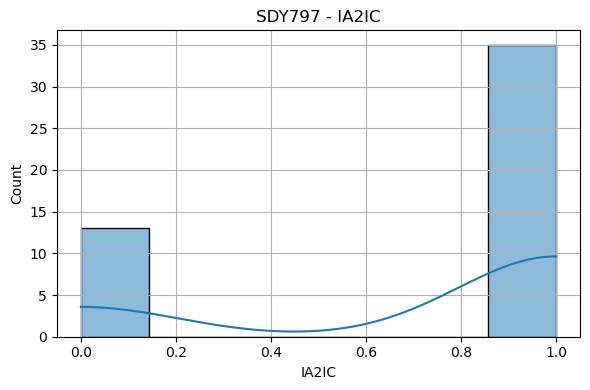

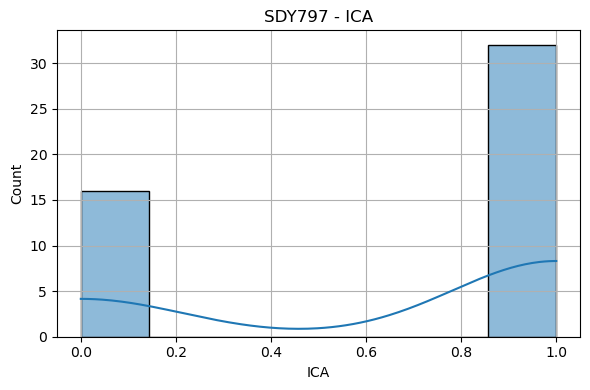

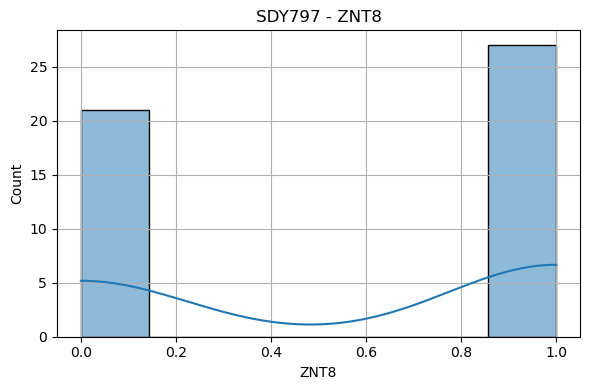


Distributions for SDY1737:


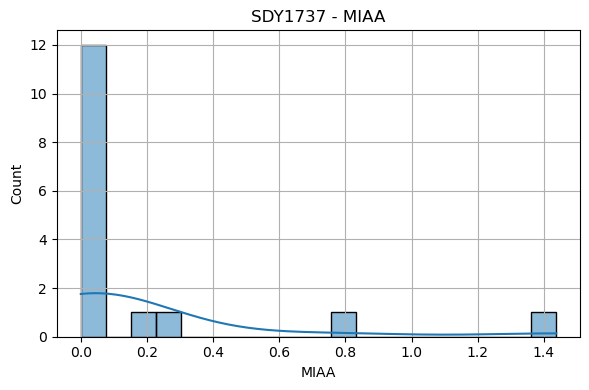

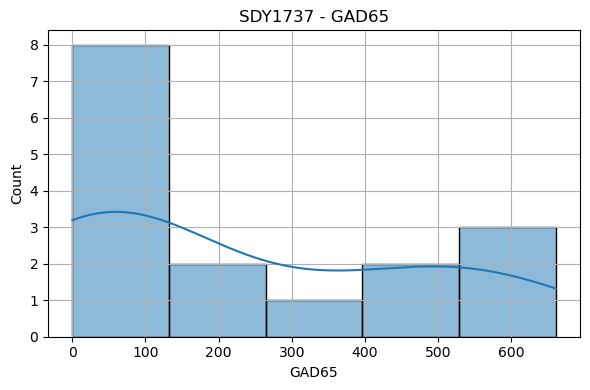

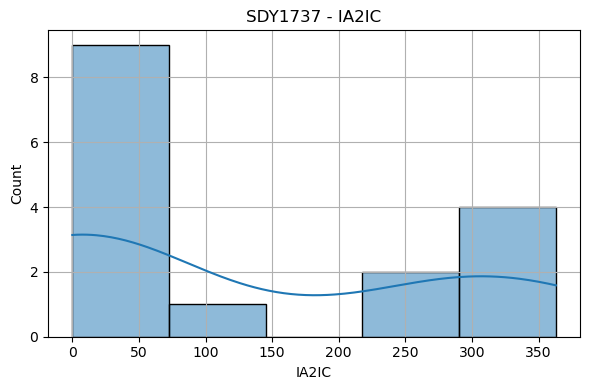

  [SKIP] ICA not found in SDY1737


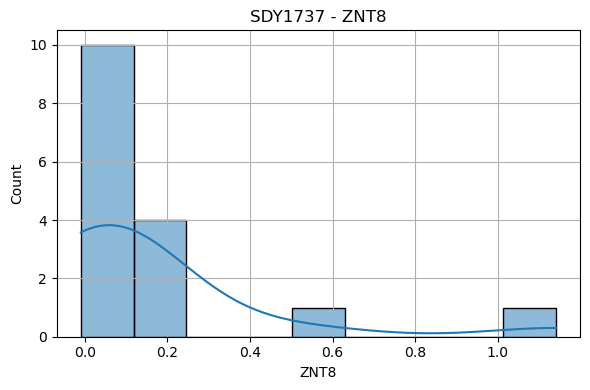

In [6]:
# Plot feature distributions
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ["MIAA", "GAD65", "IA2IC", "ICA", "ZNT8"]

for study, df in wide_feature_dfs.items():
    print(f"\nDistributions for {study}:")
    for feature in features_to_plot:
        if feature in df.columns:
            plt.figure(figsize=(6, 4))
            sns.histplot(df[feature], kde=True)
            plt.title(f"{study} - {feature}")
            plt.xlabel(feature)
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"  [SKIP] {feature} not found in {study}")


In [7]:
import numpy as np
import pandas as pd

# Antibodies and encoded demographic features
antibody_cols = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8"]
expected_age_groups = ["8-12", "13-17", ">18"]  # Recode 18-30 → >18
sex_map = {"Male": 0, "Female": 1}

ridge_ready_dfs = {}

for study, df in merged_dfs.items():
    print(f"\nPreparing Ridge input for {study}")

    df = df.copy()

    # --- Recode Age_Group ---
    df["Age_Group"] = df["Age_Group"].replace({"18-30": ">18"})  # Apply correction

    # --- Pivot antibodies ---
    df_ab = df[df["Property"].isin(antibody_cols)]
    df_ab = df_ab.pivot_table(index="Subject_ID", columns="Property", values="Value", aggfunc="first")

    # --- Encode demographics ---
    df_demo = df[["Subject_ID", "Age_Group", "Sex"]].drop_duplicates().set_index("Subject_ID")
    df_demo["Sex"] = df_demo["Sex"].map(sex_map).fillna(0).astype(int)

    age_dummies = pd.get_dummies(df_demo["Age_Group"])
    age_dummies = age_dummies.reindex(columns=expected_age_groups, fill_value=0)

    df_demo_encoded = pd.concat([age_dummies, df_demo[["Sex"]]], axis=1)

    # --- Combine antibodies + demographics ---
    X = pd.concat([df_ab, df_demo_encoded], axis=1).dropna()

    # --- Match target values ---
    df_targets = df[["Subject_ID", "C_Peptide_AUC_4Hrs"]].drop_duplicates().set_index("Subject_ID")
    df_targets = df_targets.loc[X.index]
    y = np.log(df_targets["C_Peptide_AUC_4Hrs"].values)

    # --- Final alignment ---
    ridge_ready_dfs[study] = {
        "X": X,
        "y": y
    }

    print(f"  X shape: {X.shape}, y shape: {y.shape}")
    print("  Sample features:")
    print(X.head(3))
    print("  Sample y (log C-peptide):")
    print(y[:3])



Preparing Ridge input for SDY569
  X shape: (10, 7), y shape: (10,)
  Sample features:
            GAD65  IA2IC  MIAA   8-12  13-17    >18  Sex
Subject_ID                                              
SUB151307   0.040   0.71  2.08   True  False  False    1
SUB151308   0.430   0.00  0.01  False  False   True    0
SUB151309   0.343   0.26  0.05   True  False  False    0
  Sample y (log C-peptide):
[-0.57536414 -0.33463393 -1.24653242]

Preparing Ridge input for SDY797
  X shape: (47, 9), y shape: (47,)
  Sample features:
            GAD65  IA2IC  ICA  MIAA  ZNT8  8-12  13-17  >18  Sex
Subject_ID                                                      
SUB168890     1.0    0.0  1.0   1.0   1.0  True      0    0    0
SUB168891     1.0    0.0  1.0   1.0   0.0  True      0    0    1
SUB168892     1.0    1.0  1.0   1.0   1.0  True      0    0    0
  Sample y (log C-peptide):
[-0.15078673 -0.25896424 -0.64781657]

Preparing Ridge input for SDY1737
  X shape: (16, 8), y shape: (16,)
  Sample fea

In [8]:
import numpy as np
import pandas as pd

# Antibodies and encoded demographic features
antibody_cols = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8"]
expected_age_groups = ["8-12", "13-17", ">18"]
sex_map = {"Male": 0, "Female": 1}

ridge_ready_dfs = {}

for study, df in merged_dfs.items():
    print(f"\nPreparing Ridge input for {study}")

    df = df.copy()

    # Recode Age_Group
    df["Age_Group"] = df["Age_Group"].replace({"18-30": ">18"})

    # Pivot antibodies
    df_ab = df[df["Property"].isin(antibody_cols)]
    df_ab = df_ab.pivot_table(index="Subject_ID", columns="Property", values="Value", aggfunc="first")

    # Encode demographics
    df_demo = df[["Subject_ID", "Age_Group", "Sex"]].drop_duplicates().set_index("Subject_ID")
    df_demo["Sex"] = df_demo["Sex"].map(sex_map).fillna(0).astype(int)
    age_dummies = pd.get_dummies(df_demo["Age_Group"])
    age_dummies = age_dummies.reindex(columns=expected_age_groups, fill_value=0)

    df_demo_encoded = pd.concat([age_dummies, df_demo[["Sex"]]], axis=1)

    # Combine features
    X = pd.concat([df_ab, df_demo_encoded], axis=1).dropna()

    # Align and extract log(C-peptide AUC)
    df_targets = df[["Subject_ID", "C_Peptide_AUC_4Hrs"]].drop_duplicates().set_index("Subject_ID")
    df_targets = df_targets.loc[X.index]
    y = np.log(df_targets["C_Peptide_AUC_4Hrs"].values)

    ridge_ready_dfs[study] = {
        "X": X,
        "y": y
    }

    print(f"  X shape: {X.shape}, y shape: {y.shape}")
    print("  Sample features:")
    print(X.head(3))
    print("  Sample y (log C-peptide):")
    print(y[:3])



Preparing Ridge input for SDY569
  X shape: (10, 7), y shape: (10,)
  Sample features:
            GAD65  IA2IC  MIAA   8-12  13-17    >18  Sex
Subject_ID                                              
SUB151307   0.040   0.71  2.08   True  False  False    1
SUB151308   0.430   0.00  0.01  False  False   True    0
SUB151309   0.343   0.26  0.05   True  False  False    0
  Sample y (log C-peptide):
[-0.57536414 -0.33463393 -1.24653242]

Preparing Ridge input for SDY797
  X shape: (47, 9), y shape: (47,)
  Sample features:
            GAD65  IA2IC  ICA  MIAA  ZNT8  8-12  13-17  >18  Sex
Subject_ID                                                      
SUB168890     1.0    0.0  1.0   1.0   1.0  True      0    0    0
SUB168891     1.0    0.0  1.0   1.0   0.0  True      0    0    1
SUB168892     1.0    1.0  1.0   1.0   1.0  True      0    0    0
  Sample y (log C-peptide):
[-0.15078673 -0.25896424 -0.64781657]

Preparing Ridge input for SDY1737
  X shape: (16, 8), y shape: (16,)
  Sample fea


===== Ridge regression for SDY569 =====
Mean MSE:   0.5847
Median MSE: 0.7278
IQR:        0.5524

Regression coefficients:
13-17    1.577163
MIAA     0.483656
IA2IC    0.348196
>18      0.000000
Sex      0.000000
8-12    -1.577163
GAD65   -1.824218
dtype: float64
Intercept: 0.8568


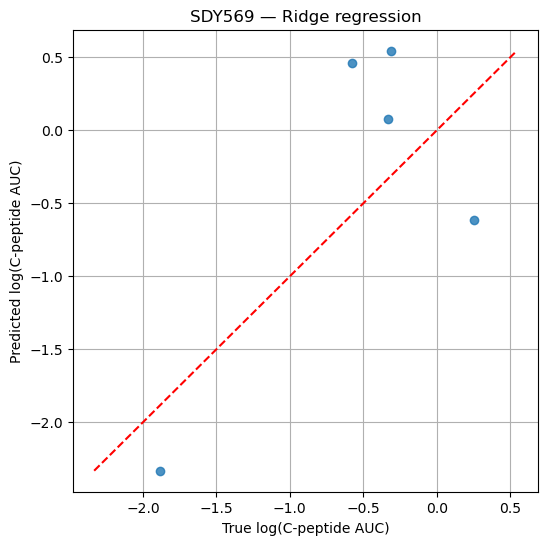


===== Ridge regression for SDY797 =====
Mean MSE:   0.3085
Median MSE: 0.1516
IQR:        0.3227

Regression coefficients:
MIAA     0.249445
ZNT8     0.198596
Sex      0.178211
IA2IC    0.140478
GAD65    0.054364
8-12     0.000000
13-17    0.000000
>18      0.000000
ICA     -0.039007
dtype: float64
Intercept: -0.6883


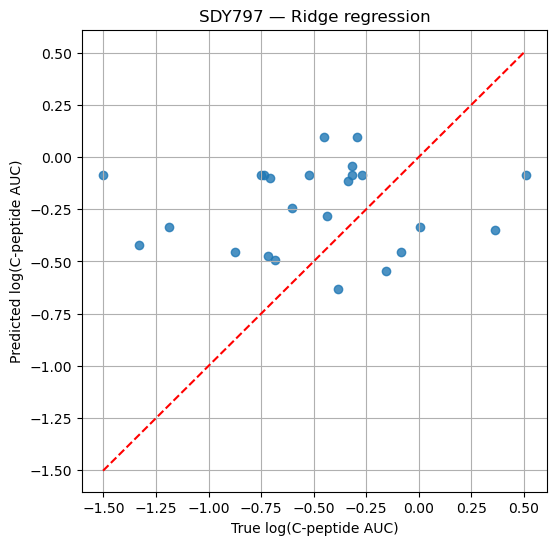


===== Ridge regression for SDY1737 =====
Mean MSE:   6.2818
Median MSE: 6.0071
IQR:        9.4188

Regression coefficients:
ZNT8     5.391454
Sex      3.605986
MIAA     2.454149
13-17    1.799464
GAD65   -0.002079
IA2IC   -0.003034
8-12    -0.314387
>18     -1.485077
dtype: float64
Intercept: -2.1661


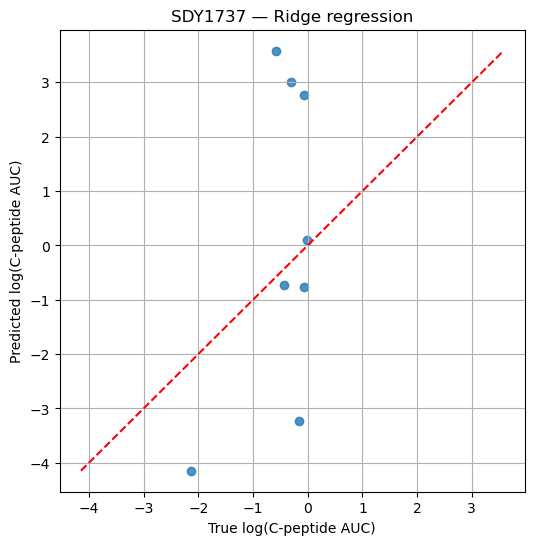

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

ridge_results = {}

for study, data in ridge_ready_dfs.items():
    print(f"\n===== Ridge regression for {study} =====")

    X = data["X"].values
    y = data["y"]

    # Train / test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42
    )

    # Fit ridge
    ridge = Ridge(alpha=0.001)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    # Metrics
    squared_errors = (y_test - y_pred) ** 2
    mean_mse   = np.mean(squared_errors)
    median_mse = np.median(squared_errors)
    iqr        = np.percentile(squared_errors, 75) - np.percentile(squared_errors, 25)

    print(f"Mean MSE:   {mean_mse:.4f}")
    print(f"Median MSE: {median_mse:.4f}")
    print(f"IQR:        {iqr:.4f}")

    # Regression equation
    coef_table = pd.Series(ridge.coef_, index=data["X"].columns)
    intercept = ridge.intercept_

    print("\nRegression coefficients:")
    print(coef_table.sort_values(ascending=False))
    print(f"Intercept: {intercept:.4f}")

    # Scatter plot (log scale)
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.8)
    lims = [
        min(y_test.min(), y_pred.min()),
        max(y_test.max(), y_pred.max())
    ]
    plt.plot(lims, lims, "r--")
    plt.xlabel("True log(C‑peptide AUC)")
    plt.ylabel("Predicted log(C‑peptide AUC)")
    plt.title(f"{study} — Ridge regression")
    plt.grid(True)
    plt.show()

    ridge_results[study] = {
        "model": ridge,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "mean_mse": mean_mse,
        "median_mse": median_mse,
        "iqr": iqr,
        "coefficients": coef_table,
        "intercept": intercept
    }


In [17]:
# Step 1: Get the union of all feature names across studies
all_features = set()
for result in ridge_results.values():
    all_features.update(result["coefficients"].index.tolist())
all_features = sorted(all_features)  # consistent ordering

# Step 2: Reindex all local coefficient Series to this common set
coefs_aligned = []
intercepts = []

for result in ridge_results.values():
    coef_series = result["coefficients"].reindex(all_features, fill_value=0.0)
    coefs_aligned.append(coef_series.values)  # now same length
    intercepts.append(result["intercept"])

# Step 3: Stack safely
coefs_array = np.vstack(coefs_aligned)
intercepts_array = np.array(intercepts)

# Step 4: Median + IQR
federated_median_coef = np.median(coefs_array, axis=0)
coef_iqr = np.percentile(coefs_array, 75, axis=0) - np.percentile(coefs_array, 25, axis=0)

federated_median_intercept = np.median(intercepts_array)
intercept_iqr = np.percentile(intercepts_array, 75) - np.percentile(intercepts_array, 25)

# Step 5: Display
print("=== Federated Ridge Model (Median + IQR) ===")
print("Feature           Median     IQR")
print("-------------------------------")
for name, med, iqr_val in zip(all_features, federated_median_coef, coef_iqr):
    print(f"{name:<15s} {med: .6f}   {iqr_val: .6f}")
print(f"\nIntercept:        {federated_median_intercept:.6f}   IQR: {intercept_iqr:.6f}")


=== Federated Ridge Model (Median + IQR) ===
Feature           Median     IQR
-------------------------------
13-17            1.577163    0.899732
8-12            -0.314387    0.788582
>18              0.000000    0.742539
GAD65           -0.002079    0.939291
IA2IC            0.140478    0.175615
ICA              0.000000    0.019504
MIAA             0.483656    1.102352
Sex              0.178211    1.802993
ZNT8             0.198596    2.695727

Intercept:        -0.688281   IQR: 1.511434


In [20]:
# From previous step
federated_median_coef      # shape (n_features,)
federated_median_intercept
all_features               # list of feature names (aligned)


['13-17', '8-12', '>18', 'GAD65', 'IA2IC', 'ICA', 'MIAA', 'Sex', 'ZNT8']


=== Federated Model Evaluation on SDY569 ===
  Mean MSE:   0.5620
  Median MSE: 0.5758
  IQR:        0.6114


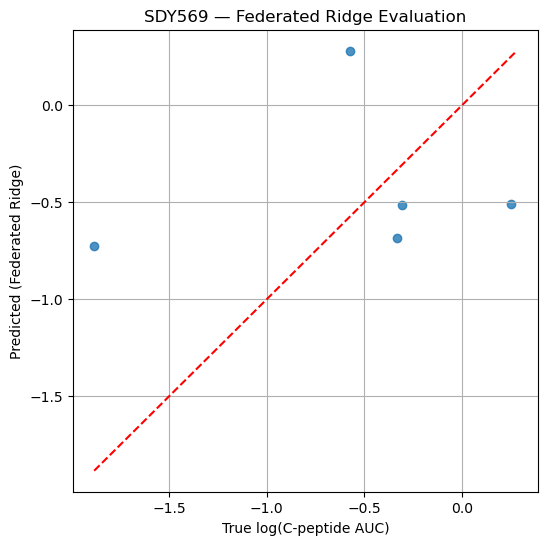


=== Federated Model Evaluation on SDY797 ===
  Mean MSE:   0.3142
  Median MSE: 0.2387
  IQR:        0.4357


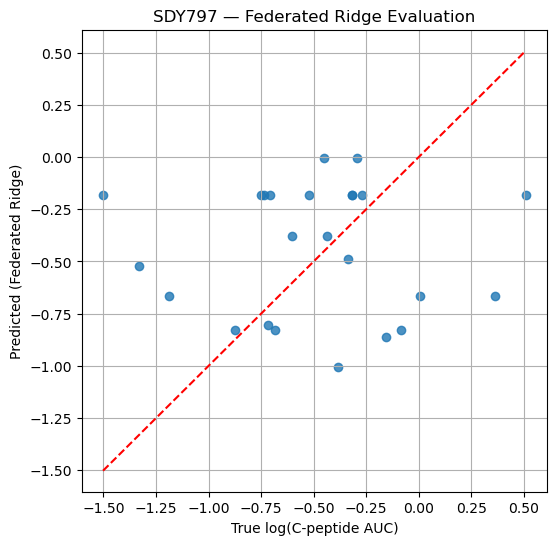


=== Federated Model Evaluation on SDY1737 ===
  Mean MSE:   711.4209
  Median MSE: 2.6731
  IQR:        1545.1433


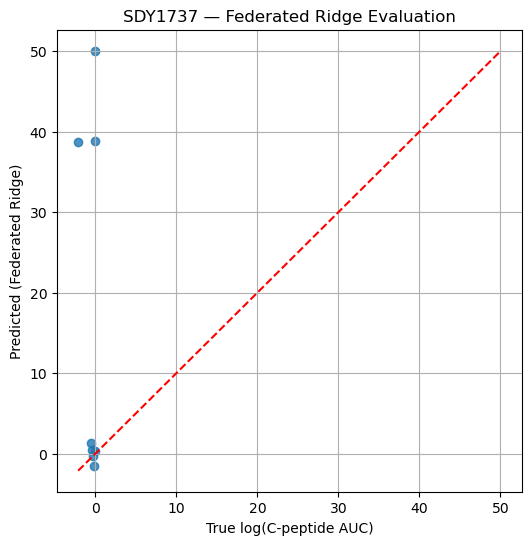

In [21]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

federated_eval_results = {}

for study, result in ridge_results.items():
    print(f"\n=== Federated Model Evaluation on {study} ===")

    # Extract aligned test features
    X_test_df = pd.DataFrame(result["X_test"], columns=result["coefficients"].index)
    X_test_aligned = X_test_df.reindex(columns=all_features, fill_value=0.0).values

    # Predict
    y_pred_fed = np.dot(X_test_aligned, federated_median_coef) + federated_median_intercept
    y_true     = result["y_test"]

    # Metrics
    squared_errors = (y_true - y_pred_fed) ** 2
    mean_mse   = np.mean(squared_errors)
    median_mse = np.median(squared_errors)
    iqr        = np.percentile(squared_errors, 75) - np.percentile(squared_errors, 25)

    print(f"  Mean MSE:   {mean_mse:.4f}")
    print(f"  Median MSE: {median_mse:.4f}")
    print(f"  IQR:        {iqr:.4f}")

    # Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred_fed, alpha=0.8)
    lims = [min(y_true.min(), y_pred_fed.min()), max(y_true.max(), y_pred_fed.max())]
    plt.plot(lims, lims, "r--")
    plt.xlabel("True log(C‑peptide AUC)")
    plt.ylabel("Predicted (Federated Ridge)")
    plt.title(f"{study} — Federated Ridge Evaluation")
    plt.grid(True)
    plt.show()

    # Save results
    federated_eval_results[study] = {
        "y_true": y_true,
        "y_pred": y_pred_fed,
        "mean_mse": mean_mse,
        "median_mse": median_mse,
        "iqr": iqr
    }
